### Pyspark Network Perfomance metrics

#####  Overview
This notebook presents a data engineering project focused on analyzing network performance metrics for a telecommuniction comapny like Safaricom PLC. The project involves extracting, transforming, and analyzing data related to latency, throughput, and packet loss rate in the network.

In [102]:
# Importing necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, hour ,avg, dayofmonth, corr
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
# initialize SparkSession
spark = SparkSession.builder.appName("network_performance_metrics_analysis").getOrCreate()

In [104]:
# load data
network_performance_metrics_df = spark.read.csv("/home/paulet/Documents/pysparkanalysis/data/network_performance_metrics.csv", header=True, inferSchema=True)

In [105]:
# show schema
network_performance_metrics_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- latency_ms: double (nullable = true)
 |-- throughput_mbps: double (nullable = true)
 |-- packet_loss_rate: double (nullable = true)



In [106]:
# statistical summary
network_performance_metrics_df.describe().show()

+-------+------------------+------------------+--------------------+
|summary|        latency_ms|   throughput_mbps|    packet_loss_rate|
+-------+------------------+------------------+--------------------+
|  count|              1440|              1440|                1440|
|   mean| 50.01295757105072| 99.62061914450055| 0.05044962091726701|
| stddev| 9.971279582366437| 19.60846164634431| 0.02811124811787327|
|    min|17.112643983377808| 26.48719167889837|1.609966591485823...|
|    max|  84.0623551325716|163.70069062489142| 0.09991531184401642|
+-------+------------------+------------------+--------------------+



In [107]:
# show data
network_performance_metrics_df.show()

+-------------------+------------------+------------------+--------------------+
|          timestamp|        latency_ms|   throughput_mbps|    packet_loss_rate|
+-------------------+------------------+------------------+--------------------+
|2024-01-01 00:00:00| 30.22672692263509|103.81442284036933| 0.05848434185107252|
|2024-01-01 00:01:00|  75.2217500083831|116.02002637207296| 0.07743411530854874|
|2024-01-01 00:02:00| 47.09360635913823| 78.75980455895356|0.011010082058706672|
|2024-01-01 00:03:00|45.191794389659734| 91.46715836703983| 0.09123455090187797|
|2024-01-01 00:04:00| 62.42998176131532| 65.65395926306566| 0.05250379366468843|
|2024-01-01 00:05:00| 55.80779092823291|118.32708914540385|  0.0456596167360615|
|2024-01-01 00:06:00| 49.02897114033033|110.48059779579913|0.021280059622242855|
|2024-01-01 00:07:00| 42.00227798466721| 85.59681759616495|0.002414019224481634|
|2024-01-01 00:08:00|53.768545202499794| 83.72997212868727|0.054988664123178314|
|2024-01-01 00:09:00| 64.215

## Data Cleaning and Preprocessing

### Overview
Data cleaning and preprocessing are essential steps to ensure the quality and reliability of the analysis, particularly in the telecommunications domain where accurate data is crucial for network performance evaluation.

### Steps Taken:
1. **Handling Null Values**: 
   - Null values were dropped from the dataset to ensure data integrity and avoid bias in the analysis. Null values can distort network performance metrics and impact decision-making processes.

2. **Checking for Duplicates**:
   - The dataset was examined for duplicate records, which could skew the analysis and lead to incorrect conclusions. No duplicates were found, indicating the dataset's integrity.

3. **Timestamp Conversion**:
   - The timestamp column was converted to a proper timestamp data type to facilitate time-based analysis and ensure consistency in time-related operations. This allows for accurate tracking of network performance over time.


In [108]:
# dropping nulls
network_performance_metrics_df = network_performance_metrics_df.dropna()

In [109]:
# checking for duplicates
duplicate_records = network_performance_metrics_df.groupBy(network_performance_metrics_df.columns).count().where(col("count") > 1)

if duplicate_records.count() > 0:
    print("Duplicate Records:")
    duplicate_records.show()
else:
    print("No duplicate records found.")

No duplicate records found.


In [110]:
# Convert the timestamp column to a proper timestamp data type
network_performance_metrics_df = network_performance_metrics_df.withColumn("timestamp", network_performance_metrics_df["timestamp"].cast("timestamp"))

### Next Steps:
With the data cleaned and preprocessed, we are now ready to proceed with data analysis and visualization to gain insights into the company's network performance metrics.


## Data Analysis

### Latency Analysis

In [111]:
avg_latency_per_hour = network_performance_metrics_df.groupBy(hour("timestamp").alias("hour")).agg({"latency_ms": "avg"}).orderBy("hour")
print("Average Latency per Hour:")
avg_latency_per_hour.show(24)

Average Latency per Hour:
+----+------------------+
|hour|   avg(latency_ms)|
+----+------------------+
|   0| 51.29397984138574|
|   1| 49.72879384043335|
|   2|  49.4763867069669|
|   3| 48.89055933597853|
|   4| 49.34900261878351|
|   5|50.860073872127344|
|   6| 50.07200075054519|
|   7| 49.88287614452016|
|   8| 51.37714274496668|
|   9| 47.96665614375497|
|  10|  51.5925122542885|
|  11| 48.40439363238451|
|  12|48.791218623407374|
|  13| 53.45899434100713|
|  14|49.423650918365574|
|  15| 50.00145587868458|
|  16| 50.08747707292711|
|  17|50.644617301503374|
|  18|52.076203905419014|
|  19| 48.42125314352192|
|  20|48.893958388785606|
|  21| 51.19822718360665|
|  22|49.877896258541114|
|  23|  48.5416508033128|
+----+------------------+



### Average Latency per Hour Analysis

The table displays the average latency per hour across the company's network. Latency is the delay in data transmission.It is a critical metric affecting user experience. By analyzing latency trends on an hourly basis, the comapny gains insights into network performance variations throughout the day. This allows for targeted optimizations and resource allocation to enhance service reliability and customer satisfaction.

Each row represents an hour of the day (from 0 to 23), along with the corresponding average latency in milliseconds (latency_ms). For example, the average latency during the early morning hours  3 AM may be relatively low due to lower network traffic, while peak hours 7 PM may experience higher latency values as network usage peaks.


In [112]:
max_latency_per_day = network_performance_metrics_df.groupBy(dayofmonth("timestamp").alias("day")).agg({"latency_ms": "max"}).orderBy("day")
print("Max Latency per day:")
max_latency_per_day.show()


Max Latency per day:


+---+----------------+
|day| max(latency_ms)|
+---+----------------+
|  1|84.0623551325716|
+---+----------------+



Maximum latency observed for a single day.Higher maximum latency values may suggest periods of network congestion or infrastructure issues during the day.Addressing these peak latency periods can help Safaricom improve service reliability and enhance customer satisfaction

In [113]:
latency_values = network_performance_metrics_df.select("latency_ms").rdd.flatMap(lambda x: x).collect()
print("Latency Values:")
print(latency_values)

Latency Values:
[30.22672692263509, 75.2217500083831, 47.09360635913823, 45.191794389659734, 62.42998176131532, 55.80779092823291, 49.02897114033033, 42.00227798466721, 53.768545202499794, 64.21533031618064, 53.565602486610736, 63.13958057001169, 55.48264234252027, 37.63728624404012, 39.121050149500746, 55.36491861946655, 53.17240971152681, 69.23316853382936, 46.68824233211299, 53.81442561270482, 67.98694778862105, 50.567194865859875, 29.033876490671844, 56.251261302720515, 56.47363638237086, 50.098929561284706, 49.05768545015851, 43.92924957447211, 51.681953207390336, 48.69292208098067, 58.73257958580004, 61.781216468253604, 48.87445000863486, 66.22492752704663, 54.30674220089207, 43.451287645494034, 68.97813456243597, 56.02935604603735, 49.213744262522, 33.99969460648617, 46.06427396793895, 34.3748006448137, 41.95224649767425, 48.48981616653308, 47.70999786672357, 54.75817984259892, 52.12905260579176, 54.32537171225455, 49.72890855100802, 46.819494011179714, 47.40425318657535, 48.647

The RDD contains latency values, representing the delay in data transmission across the network.Converting latency values to RDD in PySpark enables scalable, fault-tolerant, and efficient analysis of network performance data

### Throughput_mbps analysis

In [114]:
avg_throughput_per_hour = network_performance_metrics_df.groupBy(hour("timestamp").alias("hour")).agg({"throughput_mbps": "avg"}).orderBy("hour")
print("Average Throughput per Hour:")
avg_throughput_per_hour.show(24)

Average Throughput per Hour:


+----+--------------------+
|hour|avg(throughput_mbps)|
+----+--------------------+
|   0|  101.65740441258488|
|   1|   101.8792241110941|
|   2|  101.27106884497981|
|   3|   98.01657608327297|
|   4|  102.55486925108056|
|   5|   94.63644938638963|
|   6|   98.47567554416143|
|   7|    97.0442192865061|
|   8|   101.0102809324199|
|   9|   97.50556793920933|
|  10|   103.0719576146972|
|  11|   98.73042757492185|
|  12|   99.93744300330465|
|  13|  100.25270795145825|
|  14|    96.5089601627347|
|  15|   95.98230923981795|
|  16|  101.30509089208358|
|  17|  100.48174646551055|
|  18|   99.43974899171305|
|  19|   95.39050357681735|
|  20|  104.00300013877808|
|  21|  103.37771748001339|
|  22|  102.35090095738775|
|  23|   96.01100962707402|
+----+--------------------+




- Variations in throughput across hours may indicate periods of peak usage or network congestion.



In [115]:
max_throughput_per_day = network_performance_metrics_df.groupBy(dayofmonth("timestamp").alias("day")).agg({"throughput_mbps": "max"}).orderBy("day")
print("Max throughput per day:")
max_throughput_per_day.show()

Max throughput per day:
+---+--------------------+
|day|max(throughput_mbps)|
+---+--------------------+
|  1|  163.70069062489142|
+---+--------------------+



Indicates peak data transfer rates and network performance ata 163.7 mbps that day

In [116]:
throughput_values = network_performance_metrics_df.select("throughput_mbps").rdd.flatMap(lambda x: x).collect()
print("Throughput Values:")
print(throughput_values)

Throughput Values:
[103.81442284036933, 116.02002637207296, 78.75980455895356, 91.46715836703983, 65.65395926306566, 118.32708914540385, 110.48059779579913, 85.59681759616495, 83.72997212868727, 102.6005516779722, 99.92276947110228, 94.4689839503609, 104.57589462171015, 112.5152925628486, 100.32576236426733, 119.40676379475786, 121.25895070162917, 115.8276963784353, 106.38801345051235, 81.1963055807629, 124.27983291380949, 106.99856439078334, 125.75663485100833, 105.83558717351846, 51.1636097555446, 57.04768071987364, 78.3740785259381, 101.30684714191906, 96.52587715888667, 124.39001538102997, 121.21266893660085, 72.34398469527069, 86.4458563089483, 96.35760826087056, 110.77040915328875, 88.04316552248747, 125.50148605209185, 146.8165782817752, 109.88960870477509, 82.99054135061292, 101.25988744646415, 100.52226201474357, 94.12655895348526, 96.65819991116882, 80.44002126938558, 104.58715573857499, 144.6725694362548, 99.57796447129125, 124.8183431525226, 87.24148246039518, 86.4075461308

The RDD analysis of throughput values provides insights into network capacity and usage patterns.


### Packet Loss Rate Analysis

In [117]:
avg_packet_loss_rate_per_hour = network_performance_metrics_df.groupBy(hour("timestamp").alias("hour")).agg({"packet_loss_rate" : "avg"}).orderBy("hour")
print ("Average Packet Loss Rate per Hour :")
avg_packet_loss_rate_per_hour.show(24)                                                                                                            

Average Packet Loss Rate per Hour :


+----+---------------------+
|hour|avg(packet_loss_rate)|
+----+---------------------+
|   0| 0.053321085493431335|
|   1|  0.04928049455346355|
|   2|   0.0545495270429173|
|   3|   0.0478112485582932|
|   4|  0.05087921980263496|
|   5|  0.04567195603973931|
|   6| 0.051731063546412666|
|   7|  0.05188399764770229|
|   8|  0.04953798123327393|
|   9|  0.05016614601068654|
|  10| 0.046637012091486546|
|  11| 0.055535050998304365|
|  12|  0.04856238013478354|
|  13| 0.046615249342175334|
|  14| 0.051933928552494645|
|  15|  0.05135237107762201|
|  16| 0.046721918123573666|
|  17|  0.05403287306957338|
|  18|   0.0564146044745347|
|  19| 0.048085485561811456|
|  20|  0.05118441521790596|
|  21|  0.04718320874235397|
|  22| 0.053440966960014505|
|  23|  0.04825871773921801|
+----+---------------------+



- The average packet loss rate values represent the percentage of lost data packets during each hour of the day.
- Higher packet loss rates may indicate potential network congestion or reliability issues, impacting service quality.

In [118]:
max_packet_loss_rate_per_day = network_performance_metrics_df.groupBy(dayofmonth("timestamp").alias("day")).agg({"packet_loss_rate" : "max"}).orderBy("day")
print("Maximum Packet Loss Rate per Day :")
max_packet_loss_rate_per_day.show()

Maximum Packet Loss Rate per Day :
+---+---------------------+
|day|max(packet_loss_rate)|
+---+---------------------+
|  1|  0.09991531184401642|
+---+---------------------+



The maximum packet loss rate observed indicates a peak proportion of lost or discarded data packets during transmission, potentially highlighting periods of network instability or congestion

In [119]:
packet_loss_rate_values = network_performance_metrics_df.select("packet_loss_rate").rdd.flatMap(lambda x: x).collect()
print ("Packet Loss Rate Values :")
print (packet_loss_rate_values)

Packet Loss Rate Values :
[0.05848434185107252, 0.07743411530854874, 0.011010082058706672, 0.09123455090187797, 0.05250379366468843, 0.0456596167360615, 0.021280059622242855, 0.002414019224481634, 0.054988664123178314, 0.07306147051790844, 0.07797428652833095, 0.008086846778795254, 0.07564142670742284, 0.08342527164967826, 0.0958101000469463, 0.08537734696161765, 0.08227580438009988, 0.03745348397318071, 0.007476574294190974, 0.030516169816564187, 0.09688852507565243, 0.04141412114117801, 0.017518169164269105, 0.08582372974666416, 0.042523708543069354, 0.022908182866033223, 0.06881773285109503, 0.04630399224942799, 0.06988150683715948, 0.06494632074807467, 0.09864790877701463, 0.08762186628685112, 0.07040447570153145, 0.025120140105828914, 0.059181002075720274, 0.03386351437457508, 0.021030498453279724, 0.02575138561482985, 0.0647400634129659, 0.09217027988771652, 0.07576772754243828, 0.033466290189380465, 0.022911175362767912, 0.02519049263582106, 0.007804443400537431, 0.0641249825947

The analysis of packet loss rate values in RDD provides insights into network reliability and performance, aiding in the optimization of the company's telecommunications services.

## Correlation Analysis

In [120]:
correlation_matrix = network_performance_metrics_df.select(corr("latency_ms", "throughput_mbps").alias("latency_throughput_corr"),
                               corr("latency_ms", "packet_loss_rate").alias("latency_packet_loss_rate_corr"),
                               corr("throughput_mbps", "packet_loss_rate").alias("throughput_packet_loss_rate_corr"))

print("correlation matrix : ")
correlation_matrix.show()

correlation matrix : 


+-----------------------+-----------------------------+--------------------------------+
|latency_throughput_corr|latency_packet_loss_rate_corr|throughput_packet_loss_rate_corr|
+-----------------------+-----------------------------+--------------------------------+
|   0.026899205179309243|         -0.04763587603313...|             0.03107327083604004|
+-----------------------+-----------------------------+--------------------------------+



### Weak Correlation Analysis in Telecommunications

The correlation matrix between latency, throughput, and packet loss rate shows very weak linear relationships, which is important for a telecommunications company like Safaricom PLC:

- **Latency and Throughput**: Minimal impact on each other, suggesting network efficiency.
- **Latency and Packet Loss Rate**: Weakly related, indicating robust error handling.
- **Throughput and Packet Loss Rate**: Minor influence on each other, implying stable network capacity.

Overall, weak correlations suggest no significant direct relationships between these metrics, highlighting the complexity and robustness of a company's telecommunications network.


## Data Visualization

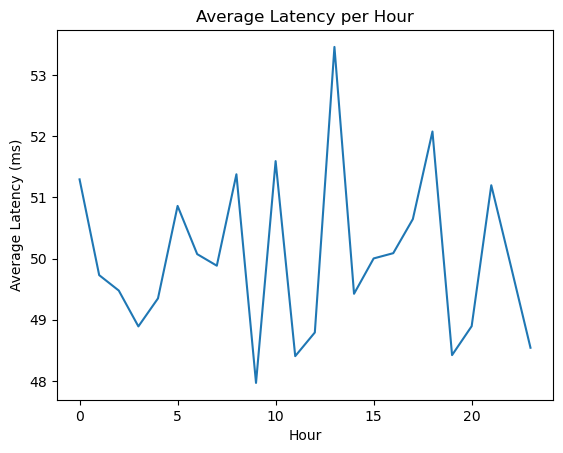

In [121]:
avg_latency_per_hour_pd = avg_latency_per_hour.toPandas()
plt.plot(avg_latency_per_hour_pd["hour"], avg_latency_per_hour_pd["avg(latency_ms)"])
plt.xlabel("Hour")
plt.ylabel("Average Latency (ms)")
plt.title("Average Latency per Hour")
plt.show()


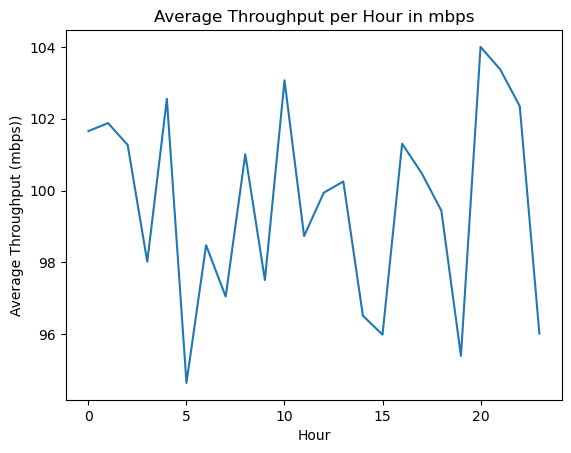

In [122]:
avg_throughput_per_hour_pd = avg_throughput_per_hour.toPandas()
plt.plot(avg_throughput_per_hour_pd["hour"], avg_throughput_per_hour_pd["avg(throughput_mbps)"])
plt.xlabel("Hour")
plt.ylabel("Average Throughput (mbps))")
plt.title("Average Throughput per Hour in mbps")
plt.show()


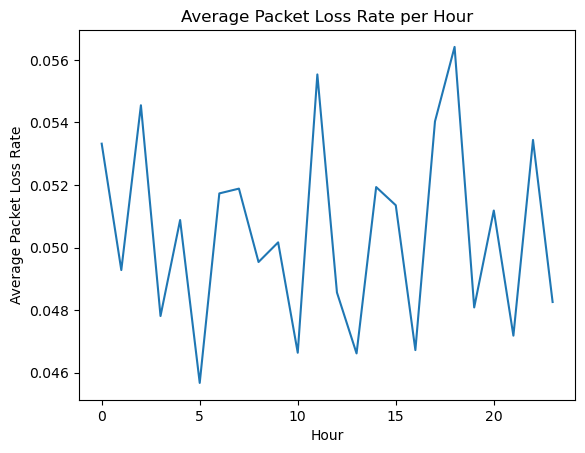

In [123]:
avg_packet_loss_rate_per_hour_pd = avg_packet_loss_rate_per_hour.toPandas()
plt.plot(avg_packet_loss_rate_per_hour_pd["hour"], avg_packet_loss_rate_per_hour_pd["avg(packet_loss_rate)"])
plt.xlabel("Hour")
plt.ylabel("Average Packet Loss Rate")
plt.title("Average Packet Loss Rate per Hour")
plt.show()

## SPARK MLLIB 

In [124]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler

In [125]:
assembler = VectorAssembler(inputCols=["latency_ms", "throughput_mbps", "packet_loss_rate"], outputCol="features")
network_performance_metrics_df = assembler.transform(network_performance_metrics_df)

In [126]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(network_performance_metrics_df)
network_performance_metrics_df = scalerModel.transform(network_performance_metrics_df)

In [127]:
# Train K-means clustering model
kmeans = KMeans(k=2, seed=123)  
model = kmeans.fit(network_performance_metrics_df)

24/02/24 14:21:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [128]:
# predictions
predictions = model.transform(network_performance_metrics_df)

In [129]:
# Show cluster centers
print("Cluster Centers:")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers:
[4.96829870e+01 8.37466116e+01 5.01637834e-02]
[5.03277056e+01 1.14762312e+02 5.07222719e-02]


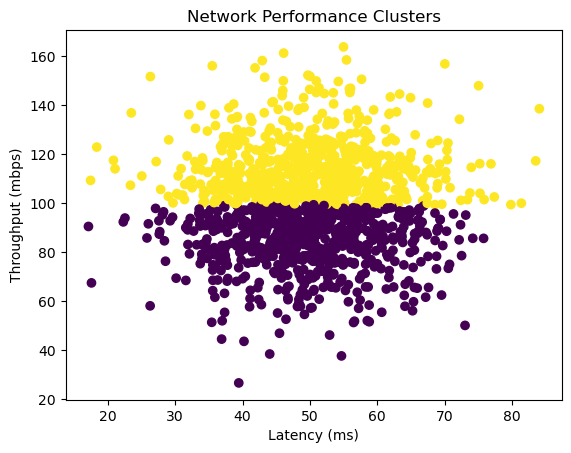

In [130]:
# Plot clusters (2D scatter plot for simplicity)
latency_values = predictions.select("latency_ms").rdd.flatMap(lambda x: x).collect()
throughput_values = predictions.select("throughput_mbps").rdd.flatMap(lambda x: x).collect()
plt.scatter(latency_values, throughput_values, c=predictions.select("prediction").collect())
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mbps)")
plt.title("Network Performance Clusters")
plt.show()

The clear separation of clusters in the plot suggests that there are distinct patterns or differences in the network performance metrics captured by the features, and the K-means algorithm has successfully identified and separated these patterns into two clusters.


Good network performance is characterized by low latency and high throughput, while bad performance is indicated by high latency and low throughput